In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import re

from ydata_profiling import ProfileReport

import sys

sys.path.append('../src')
from utils import getExperimentConfig, translate_model_name

# Get global experiment settings
config = getExperimentConfig()
folders = config['folders']

In [3]:
runs_file = f"{folders['data_dir']}runs.csv"
pf_file = f"{folders['data_dir']}new_old_pf_measures.csv"

pd.set_option('display.max_columns', None)

# Performance analysis

In [24]:
raw_runs_df = pd.read_csv(runs_file)
raw_runs_df.head(3)

,Start Time,Duration,Run ID,Name,Source Type,Source Name,User,Status,C,algorithm,class_weight,dual,fit_intercept,intercept_scaling,l1_ratio,leaf_size,max_iter,metric,metric_params,multi_class,n_jobs,n_neighbors,p,penalty,random_state,solver,tol,verbose,warm_start,weights,AUC,Accuracy,F1-score,Kappa,MCC,val_Accuracy,val_F1-score,Dataset ID,Dataset Type,model,Run ID.1,USI,model run id,model run name
0,2023-04-11 23:59:23,1.2min,e265dbdd046448f3bc4d52b82a978136,SD0Q4_0-K-Nearest Neighbor,LOCAL,C:\Users\flore\miniconda3\envs\master\lib\site...,flore,FINISHED,NaN,auto,NaN,NaN,NaN,NaN,NaN,30.0,NaN,minkowski,None,NaN,-1,5.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,uniform,0.526041,0.703125,0.697360,0.410884,0.434559,0.8616,0.8547,SD0Q4_0,synthetic,knn,e265dbdd046448f3bc4d52b82a978136,38cc,NaN,NaN
1,2023-04-11 23:58:13,1.2min,747c47e9b1b8472d8cd4e850a1d71a95,SD0Q4_0-Logistic Regression,LOCAL,C:\Users\flore\miniconda3\envs\master\lib\site...,flore,FINISHED,1.000,NaN,None,False,True,1.0,None,NaN,1000.0,NaN,NaN,auto,None,NaN,NaN,l2,4420.0,lbfgs,0.0001,0.0,False,NaN,0.613493,0.710938,0.707267,0.435204,0.468740,0.8680,0.8693,SD0Q4_0,synthetic,lr,747c47e9b1b8472d8cd4e850a1d71a95,38cc,NaN,NaN
2,2023-04-11 23:57:42,30.7s,12d336e8e7744fa9a8603f8f0b418790,SD0Q4_0-Orignal_Logistic Regression,LOCAL,C:\Users\flore\miniconda3\envs\master\lib\site...,flore,FINISHED,2.506,NaN,None,False,True,1.0,None,NaN,1000.0,NaN,NaN,auto,None,NaN,NaN,l2,202.0,lbfgs,0.0001,0.0,False,NaN,0.614657,0.709635,0.706035,0.433096,0.466925,0.8680,0.8693,SD0Q4_0,synthetic,SD0Q4_0-Orignal_Logistic Regression,12d336e8e7744fa9a8603f8f0b418790,38cc,NaN,NaN


In [50]:
#raw_runs_df['Name'].unique()

# The columns of data that will be used to analyze the results
cols_to_keep = [
    'Run ID',
    'Name',
    'Accuracy',
    'F1-score',
    'Kappa',
    'MCC',
    'AUC',
    'val_Accuracy',
    'val_F1-score',
    'Dataset ID',
    'Dataset Type',
    'model',
    'Quality'
]

# Get columns not specified in cols_to_keep and remove them
cols_to_drop = [col for col in raw_runs_df.columns if col not in cols_to_keep]
print(f"Columns that will be dropped: \n{cols_to_drop}")
runs_df = raw_runs_df.drop(columns=cols_to_drop)

# remove rows with 'models' in their name, they are a "header" row that are not needed here
runs_df=runs_df[~runs_df['Name'].str.contains('models')]
runs_df['Name'].unique()

runs_df

Columns that will be dropped: 
['Start Time', 'Duration', 'Source Type', 'Source Name', 'User', 'Status', 'C', 'algorithm', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'leaf_size', 'max_iter', 'metric', 'metric_params', 'multi_class', 'n_jobs', 'n_neighbors', 'p', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start', 'weights', 'Run ID.1', 'USI', 'model run id', 'model run name']


,Run ID,Name,AUC,Accuracy,F1-score,Kappa,MCC,val_Accuracy,val_F1-score,Dataset ID,Dataset Type,model
0,e265dbdd046448f3bc4d52b82a978136,SD0Q4_0-K-Nearest Neighbor,0.526041,0.703125,0.697360,0.410884,0.434559,0.8616,0.8547,SD0Q4_0,synthetic,knn
1,747c47e9b1b8472d8cd4e850a1d71a95,SD0Q4_0-Logistic Regression,0.613493,0.710938,0.707267,0.435204,0.468740,0.8680,0.8693,SD0Q4_0,synthetic,lr
2,12d336e8e7744fa9a8603f8f0b418790,SD0Q4_0-Orignal_Logistic Regression,0.614657,0.709635,0.706035,0.433096,0.466925,0.8680,0.8693,SD0Q4_0,synthetic,SD0Q4_0-Orignal_Logistic Regression
4,2dc7ccd11dee48ff9fd4943fb9d71fd1,SD0Q3_0-K-Nearest Neighbor,0.391015,0.708333,0.688889,0.379573,0.381924,0.7916,0.8011,SD0Q3_0,synthetic,knn
5,48ebc5b6b322404fba10776d2f0095d8,SD0Q3_0-Logistic Regression,0.478052,0.731771,0.698242,0.397147,0.398130,0.7296,0.7355,SD0Q3_0,synthetic,lr
6,c3a3ad0d07014c62ae8b6055919f418c,SD0Q3_0-Orignal_Logistic Regression,0.478049,0.729167,0.695312,0.391294,0.392262,0.7296,0.7355,SD0Q3_0,synthetic,SD0Q3_0-Orignal_Logistic Regression
8,9fd2ab3b513b438595b71b63dcc2270f,SD0Q2_0-K-Nearest Neighbor,0.369082,0.729167,0.715556,0.435230,0.441954,0.8371,0.8324,SD0Q2_0,synthetic,knn
9,35a57d4067e34a42bd87605f3e0770d4,SD0Q2_0-Logistic Regression,0.511459,0.723958,0.712079,0.429980,0.439249,0.8517,0.8566,SD0Q2_0,synthetic,lr
10,f483b9e2cb0b4d718337a631a68b6b7f,SD0Q2_0-Orignal_Logistic Regression,0.528556,0.723958,0.714187,0.436389,0.449444,0.8485,0.8549,SD0Q2_0,synthetic,SD0Q2_0-Orignal_Logistic Regression
12,d125f5730a1f42e5b649ed536f426ad7,SD0Q1_2-K-Nearest Neighbor,0.497246,0.610677,0.582656,0.166962,0.167672,0.6593,0.4933,SD0Q1_2,synthetic,knn


In [84]:
# Filter out rows with 'Original' in the 'Name' column
df = runs_df

df['Dataset ID'] =  df['Dataset ID'].str.split('_').str[0]

# Group by the starting substring and calculate the mean of specified columns
mean_columns = ['F1-score', 'Kappa', 'AUC', 'Accuracy', 'MCC', 'val_Accuracy', 'val_F1-score']
grouped = df.groupby(['Dataset ID', 'model'])[mean_columns].mean()

# Reset index to convert indices to columns
grouped = grouped.reset_index()

# Remove the 'Run ID' column
grouped = grouped.drop(['Run ID'], axis=1, errors='ignore')

grouped['TrainedOnReal'] = False

# Filter out rows with 'Original' in the 'model' column
filtered_df = grouped[~grouped['model'].str.contains('-Original_')]
lr_df = filtered_df[filtered_df['model']=='lr']

o_f1 =  lr_df[lr_df['Dataset ID']=='D0']['F1-score'][1]
o_acc = lr_df[lr_df['Dataset ID']=='D0']['Accuracy'][1]

perf = lr_df[lr_df['Dataset ID'] != 'D0']

perf['O_Accuracy'] = o_acc
perf['O_F1'] = o_f1
perf['F1_diff'] = perf['F1-score'] - o_f1
perf['Accuracy_diff'] = perf['Accuracy'] - o_acc

perf

,Dataset ID,model,F1-score,Kappa,AUC,Accuracy,MCC,val_Accuracy,val_F1-score,TrainedOnReal,O_Accuracy,O_F1,F1_diff,Accuracy_diff
6,SD0Q1,lr,0.538796,0.125437,0.547229,0.555990,0.128784,0.697033,0.668733,False,0.7646,0.6564,-0.117604,-0.208610
9,SD0Q2,lr,0.712079,0.429980,0.511459,0.723958,0.439249,0.851700,0.856600,False,0.7646,0.6564,0.055679,-0.040642
12,SD0Q3,lr,0.698242,0.397147,0.478052,0.731771,0.398130,0.729600,0.735500,False,0.7646,0.6564,0.041842,-0.032829
15,SD0Q4,lr,0.707267,0.435204,0.613493,0.710938,0.468740,0.868000,0.869300,False,0.7646,0.6564,0.050867,-0.053662


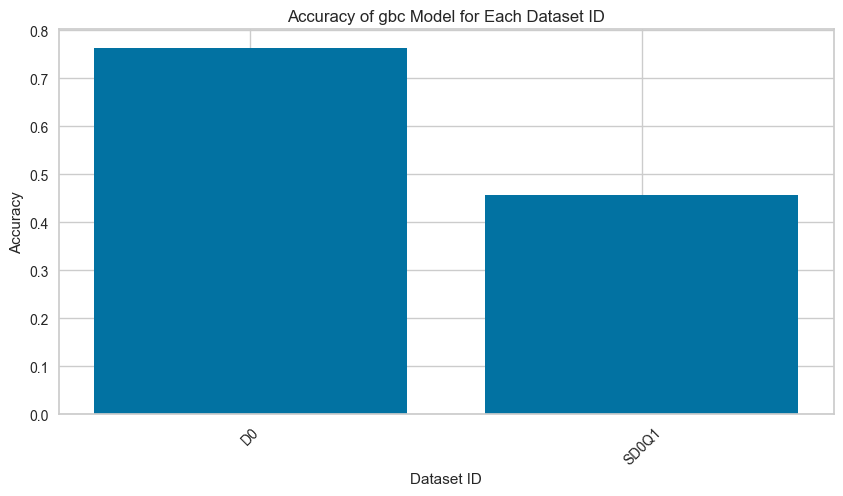

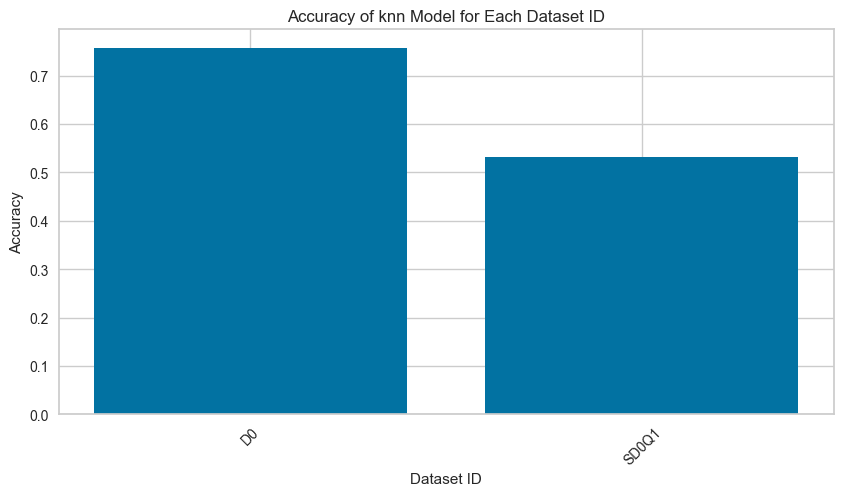

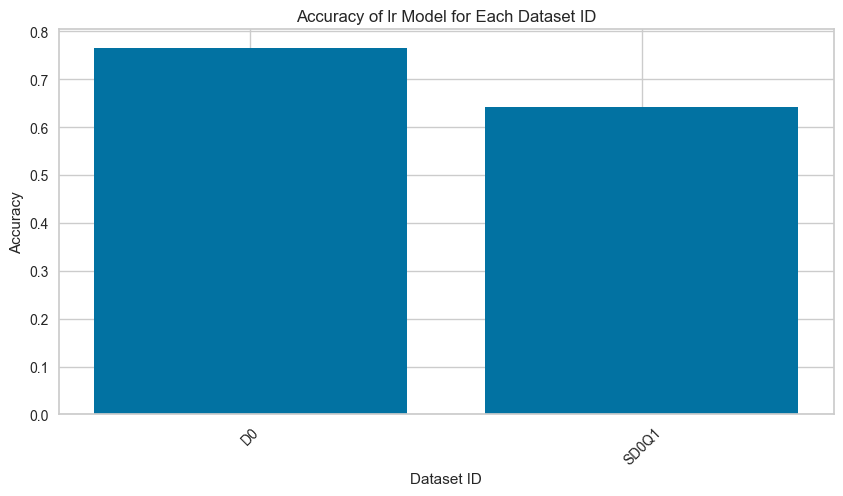

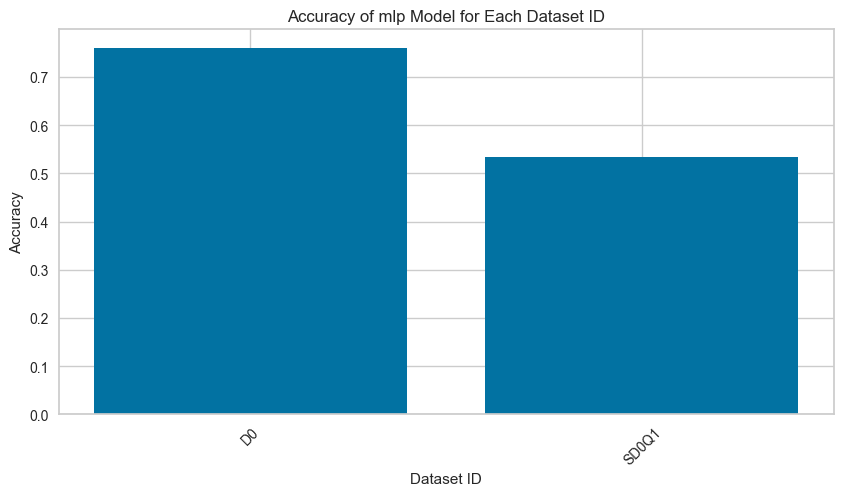

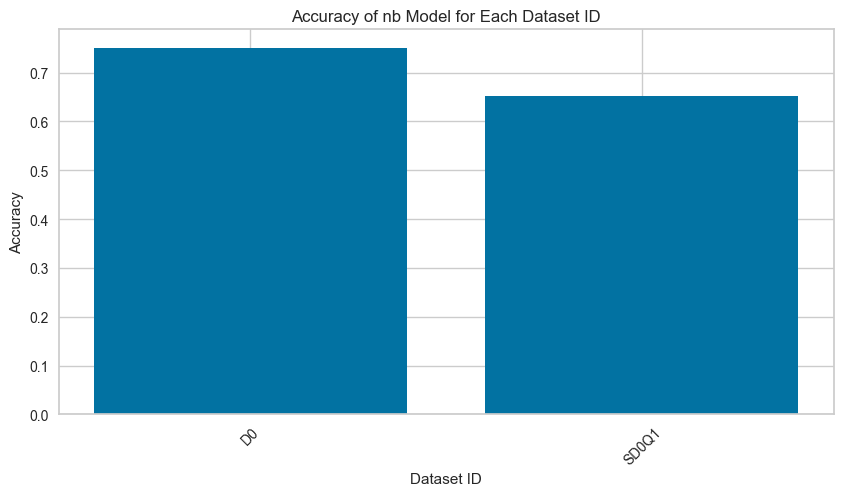

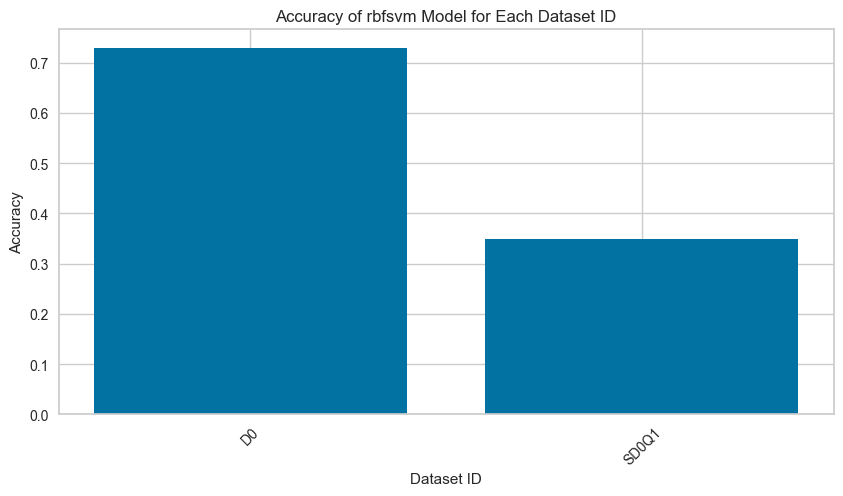

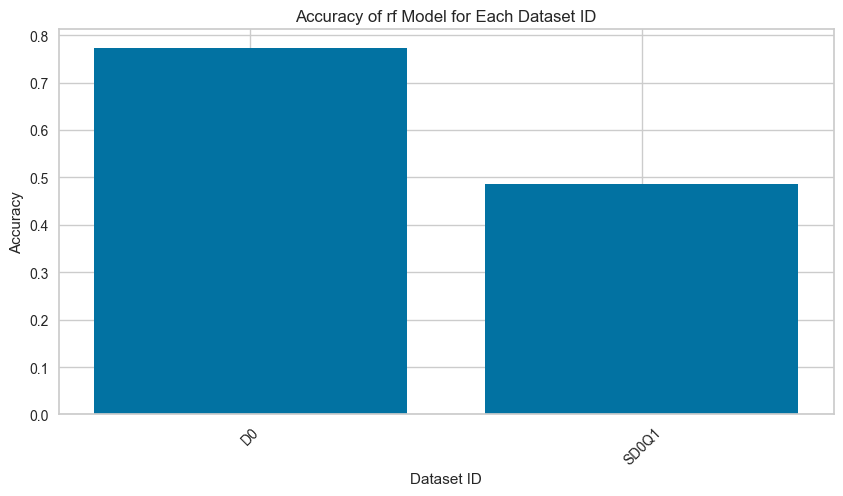

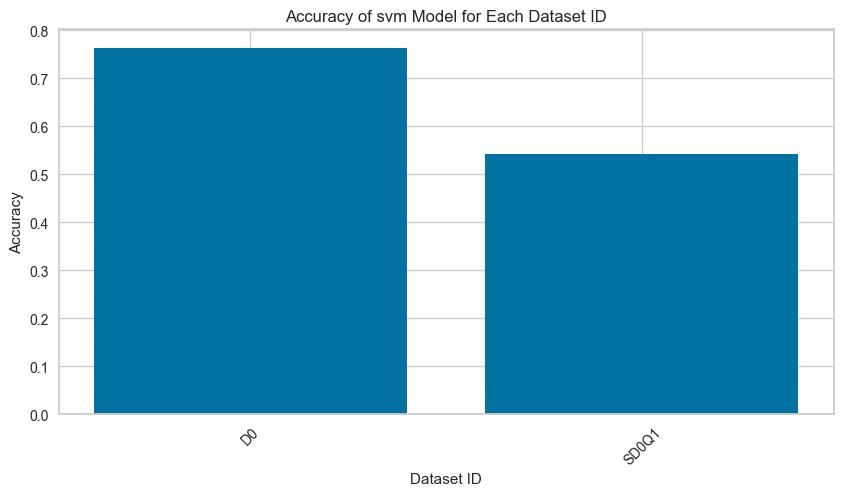

In [56]:
data = grouped
# Find unique models
models = data['model'].unique()

# Loop through the models and create a bar plot for each
for model in models:
    # Filter the data for the current model
    model_data = data[data['model'] == model]

    # Create a bar plot
    plt.figure(figsize=(10, 5))
    plt.bar(model_data['Dataset ID'], model_data['Accuracy'])
    plt.xlabel('Dataset ID')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy of {model} Model for Each Dataset ID')
    plt.xticks(rotation=45)
    plt.show()

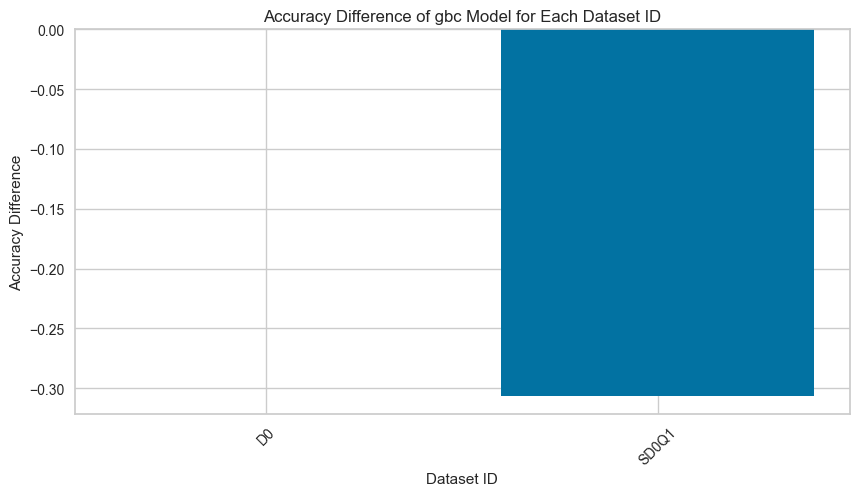

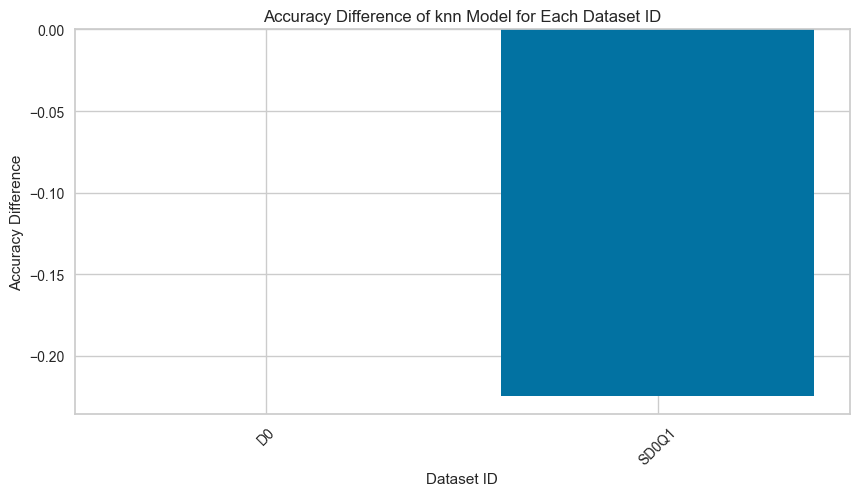

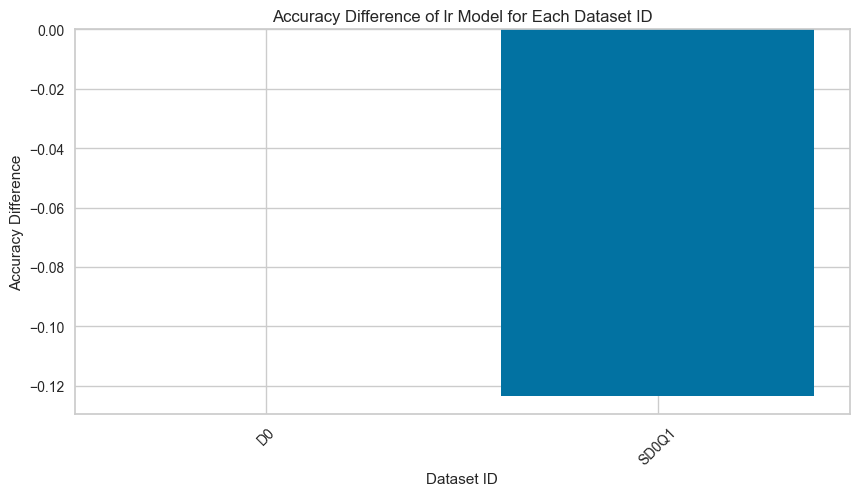

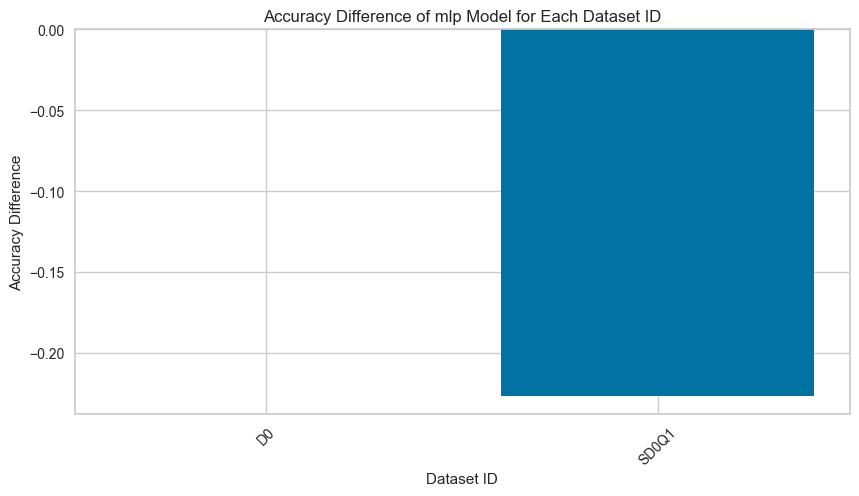

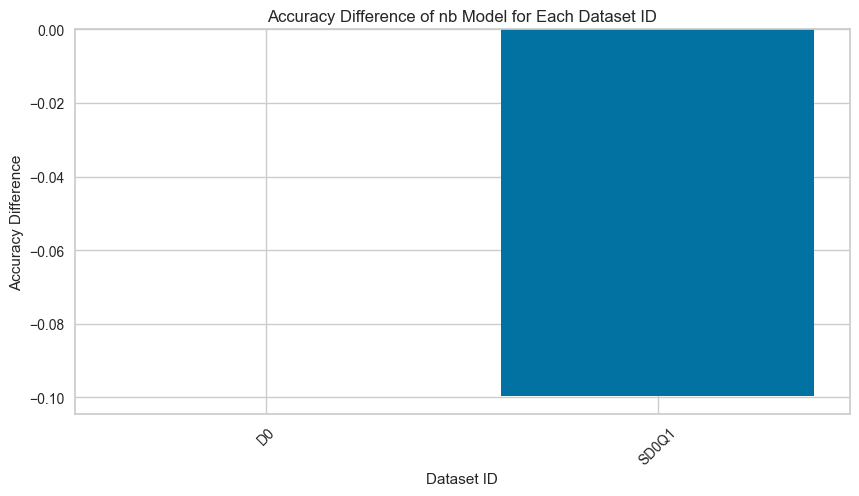

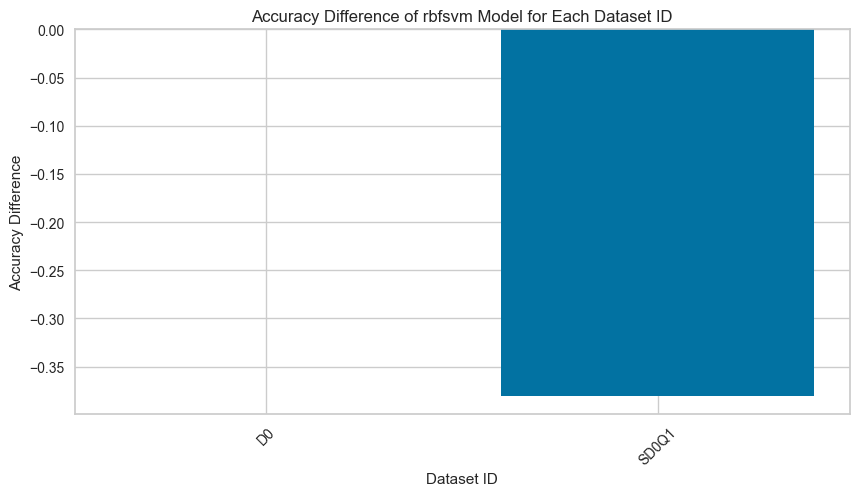

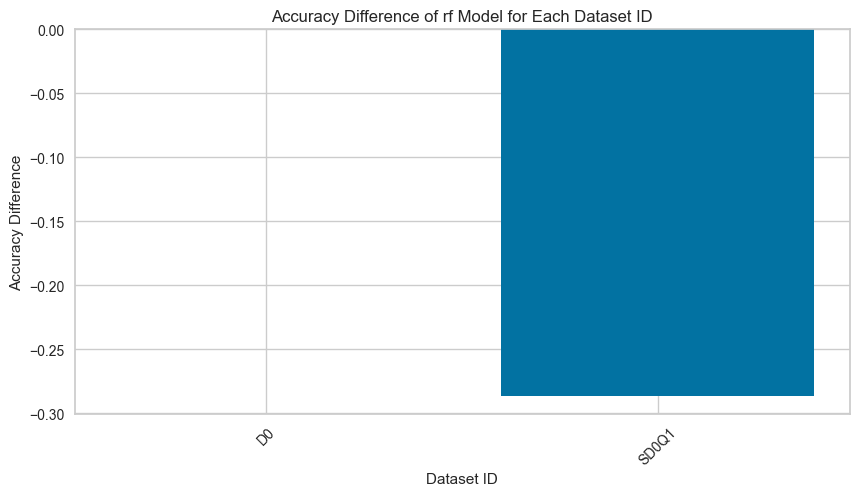

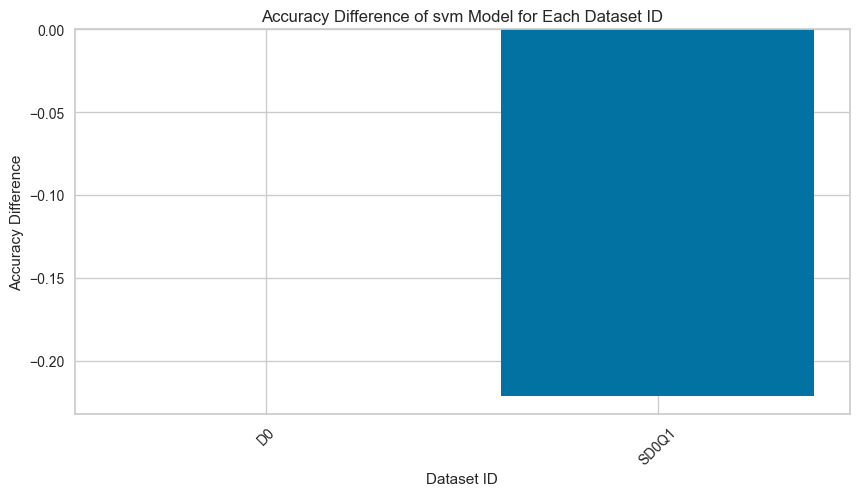

In [57]:
data = grouped
# Find unique models
models = data['model'].unique()

# Find 'Accuracy' values for rows with 'Dataset ID' containing only 'D' and a number
d_accuracies = data[data['Dataset ID'].apply(lambda x: bool(re.match(r'^D\d+$', x)))][['model', 'Accuracy']]

# Loop through the models and create a bar plot for each
for model in models:
    # Filter the data for the current model
    model_data = data[data['model'] == model]

    # Find the corresponding 'D' accuracy for the current model
    d_accuracy = d_accuracies[d_accuracies['model'] == model]['Accuracy'].values[0]

    # Compute the difference between 'Accuracy' and the corresponding 'D' accuracy
    model_data['accuracy_diff'] = model_data['Accuracy'] - d_accuracy

    # Create a bar plot
    plt.figure(figsize=(10, 5))
    plt.bar(model_data['Dataset ID'], model_data['accuracy_diff'])
    plt.xlabel('Dataset ID')
    plt.ylabel('Accuracy Difference')
    plt.title(f'Accuracy Difference of {model} Model for Each Dataset ID')
    plt.xticks(rotation=45)
    plt.show()

# PF measures analysis

In [5]:
pf_df = pd.read_csv(pf_file)

#TODO: Quickfix, To be removed after next compute_all_pf_measures run
pf_df['Quality'] =  pf_df['SDG'].str.split('D0').apply(lambda x: x[1])
pf_df.head()

,DatasetName,pMSE,pMSE_time,s_pMSE,s_pMSE_time,Cluster_1,Cluster_1_time,BNLogLikelihood,BNLogLikelihood_time,GMLogLikelihood,...,DiscreteKLDivergence,DiscreteKLDivergence_time,KSComplement,KSComplement_time,CSTest,CSTest_time,CrossClassification,CrossClassification_time,SDG,Quality
0,SD0Q1_0,0.069348,0.055415,51.132515,0.057084,7.116511,37.368192,-0.717444,0.724688,-27.700763,...,NaN,0.002732,0.823568,0.015918,0.812140,0.002635,0.209765,0.291342,SD0Q1,Q1
1,SD0Q1_1,0.066547,0.060771,66.526990,0.059244,6.597769,33.910437,-0.725564,0.087948,-28.321749,...,NaN,0.000927,0.820312,0.017270,0.791022,0.002110,0.545732,0.297663,SD0Q1,Q1
2,SD0Q1_2,0.073508,0.051315,71.483076,0.060829,7.938453,37.947017,-0.727188,0.089365,-28.623613,...,NaN,0.000905,0.809408,0.015574,0.786816,0.002145,0.522772,0.284010,SD0Q1,Q1
3,SD0Q1_3,0.065519,0.058888,54.992050,0.060081,7.085517,33.810407,-0.720692,0.088708,-27.686462,...,NaN,0.000851,0.808757,0.015835,0.803676,0.002188,0.500000,0.289074,SD0Q1,Q1
4,SD0Q1_4,0.065783,0.063401,73.977730,0.053985,6.963457,37.640761,-0.743428,0.091361,-27.565698,...,NaN,0.000890,0.816081,0.015456,0.745118,0.002092,0.515272,0.278217,SD0Q1,Q1


In [85]:
# Group by generator and compute the mean
mean_pf_df = pf_df.groupby(['SDG', 'Quality']).mean()
# Reset index to convert index
m_pf = mean_pf_df.reset_index()


display(m_pf)

,SDG,Quality,pMSE,pMSE_time,s_pMSE,s_pMSE_time,Cluster_1,Cluster_1_time,BNLogLikelihood,BNLogLikelihood_time,GMLogLikelihood,GMLogLikelihood_time,ContinousKLDivergence,ContinousKLDivergence_time,DiscreteKLDivergence,DiscreteKLDivergence_time,KSComplement,KSComplement_time,CSTest,CSTest_time,CrossClassification,CrossClassification_time
0,SD0Q1,Q1,0.069488,0.057888,63.447206,0.057618,7.255086,35.610530,-0.725564,0.153268,-28.010529,9.622024,0.560637,0.274180,NaN,0.001103,0.814860,0.015760,0.791088,0.002191,0.452644,0.282310
1,SD0Q2,Q2,0.044068,0.061777,37.769658,0.060663,4.003185,38.747981,-0.751873,0.084202,-28.622587,8.943446,0.578738,0.253902,NaN,0.000853,0.847266,0.014644,0.723895,0.002022,0.646346,0.257124
2,SD0Q3,Q3,0.015951,0.049614,14.339053,0.048079,1.338561,32.142386,-0.749843,0.076492,-26.209418,7.840083,0.747665,0.225149,NaN,0.000799,0.883171,0.013625,0.728945,0.001897,0.654986,0.237158
3,SD0Q4,Q4,0.049915,0.052522,43.168307,0.051651,5.193604,37.407272,-0.760886,0.078903,-30.915402,8.276775,0.647213,0.258930,NaN,0.000863,0.832829,0.015755,0.701181,0.002210,0.659694,0.238254


,Dataset ID,model,F1-score,Kappa,AUC,Accuracy,MCC,val_Accuracy,val_F1-score,TrainedOnReal,O_Accuracy,O_F1,F1_diff,Accuracy_diff
6,SD0Q1,lr,0.538796,0.125437,0.547229,0.555990,0.128784,0.697033,0.668733,False,0.7646,0.6564,-0.117604,-0.208610
9,SD0Q2,lr,0.712079,0.429980,0.511459,0.723958,0.439249,0.851700,0.856600,False,0.7646,0.6564,0.055679,-0.040642
12,SD0Q3,lr,0.698242,0.397147,0.478052,0.731771,0.398130,0.729600,0.735500,False,0.7646,0.6564,0.041842,-0.032829
15,SD0Q4,lr,0.707267,0.435204,0.613493,0.710938,0.468740,0.868000,0.869300,False,0.7646,0.6564,0.050867,-0.053662


In [21]:
time_columns =  [col for col in m_pf.columns if "_time" in col]
pf_columns = [col for col in m_pf.columns if ("_time" not in col and col != "SDG" and col != "Quality")]
pf_columns

['pMSE',
 's_pMSE',
 'Cluster_1',
 'BNLogLikelihood',
 'GMLogLikelihood',
 'ContinousKLDivergence',
 'DiscreteKLDivergence',
 'KSComplement',
 'CSTest',
 'CrossClassification']

In [86]:
cols = pf_columns.copy()

cols.insert(0,'Quality')
cols.insert(0,'SDG')
m_pf_metrics = m_pf[cols]
display(m_pf_metrics)
display(perf)

,SDG,Quality,pMSE,s_pMSE,Cluster_1,BNLogLikelihood,GMLogLikelihood,ContinousKLDivergence,DiscreteKLDivergence,KSComplement,CSTest,CrossClassification
0,SD0Q1,Q1,0.069488,63.447206,7.255086,-0.725564,-28.010529,0.560637,NaN,0.814860,0.791088,0.452644
1,SD0Q2,Q2,0.044068,37.769658,4.003185,-0.751873,-28.622587,0.578738,NaN,0.847266,0.723895,0.646346
2,SD0Q3,Q3,0.015951,14.339053,1.338561,-0.749843,-26.209418,0.747665,NaN,0.883171,0.728945,0.654986
3,SD0Q4,Q4,0.049915,43.168307,5.193604,-0.760886,-30.915402,0.647213,NaN,0.832829,0.701181,0.659694


,Dataset ID,model,F1-score,Kappa,AUC,Accuracy,MCC,val_Accuracy,val_F1-score,TrainedOnReal,O_Accuracy,O_F1,F1_diff,Accuracy_diff
6,SD0Q1,lr,0.538796,0.125437,0.547229,0.555990,0.128784,0.697033,0.668733,False,0.7646,0.6564,-0.117604,-0.208610
9,SD0Q2,lr,0.712079,0.429980,0.511459,0.723958,0.439249,0.851700,0.856600,False,0.7646,0.6564,0.055679,-0.040642
12,SD0Q3,lr,0.698242,0.397147,0.478052,0.731771,0.398130,0.729600,0.735500,False,0.7646,0.6564,0.041842,-0.032829
15,SD0Q4,lr,0.707267,0.435204,0.613493,0.710938,0.468740,0.868000,0.869300,False,0.7646,0.6564,0.050867,-0.053662


In [92]:
combined_data = m_pf_metrics.merge(perf, left_on=['SDG'], right_on=['Dataset ID'])
combined_data

,SDG,Quality,pMSE,s_pMSE,Cluster_1,BNLogLikelihood,GMLogLikelihood,ContinousKLDivergence,DiscreteKLDivergence,KSComplement,CSTest,CrossClassification,Dataset ID,model,F1-score,Kappa,AUC,Accuracy,MCC,val_Accuracy,val_F1-score,TrainedOnReal,O_Accuracy,O_F1,F1_diff,Accuracy_diff
0,SD0Q1,Q1,0.069488,63.447206,7.255086,-0.725564,-28.010529,0.560637,NaN,0.814860,0.791088,0.452644,SD0Q1,lr,0.538796,0.125437,0.547229,0.555990,0.128784,0.697033,0.668733,False,0.7646,0.6564,-0.117604,-0.208610
1,SD0Q2,Q2,0.044068,37.769658,4.003185,-0.751873,-28.622587,0.578738,NaN,0.847266,0.723895,0.646346,SD0Q2,lr,0.712079,0.429980,0.511459,0.723958,0.439249,0.851700,0.856600,False,0.7646,0.6564,0.055679,-0.040642
2,SD0Q3,Q3,0.015951,14.339053,1.338561,-0.749843,-26.209418,0.747665,NaN,0.883171,0.728945,0.654986,SD0Q3,lr,0.698242,0.397147,0.478052,0.731771,0.398130,0.729600,0.735500,False,0.7646,0.6564,0.041842,-0.032829
3,SD0Q4,Q4,0.049915,43.168307,5.193604,-0.760886,-30.915402,0.647213,NaN,0.832829,0.701181,0.659694,SD0Q4,lr,0.707267,0.435204,0.613493,0.710938,0.468740,0.868000,0.869300,False,0.7646,0.6564,0.050867,-0.053662


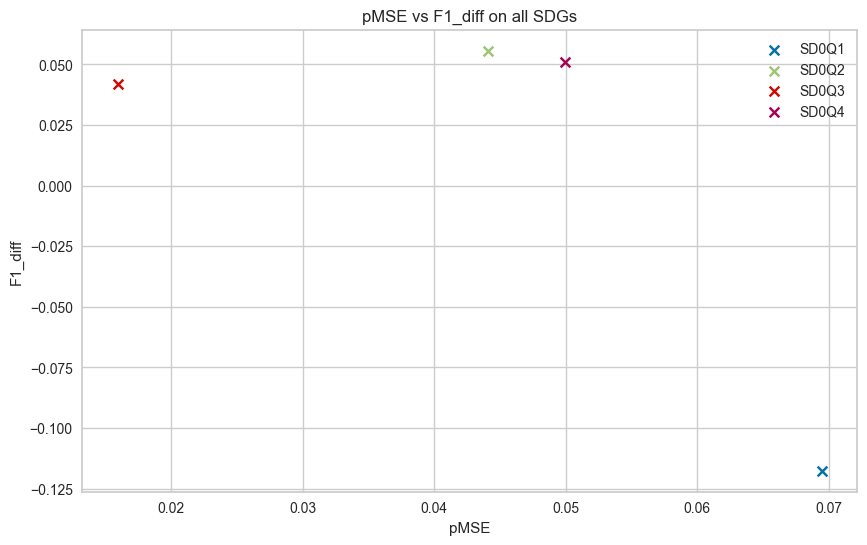

In [107]:
# Create a scatter plot for each SDG

x_axis = 'pMSE'
y_axis = 'F1_diff'

plt.figure(figsize=(10, 6))
for index, row in combined_data.iterrows():
    plt.scatter(row[x_axis], row[y_axis], label=row['SDG'], marker='x' )

# Add labels and title
plt.xlabel(x_axis)
plt.ylabel(y_axis)
plt.title(f"{x_axis} vs {y_axis} on all SDGs")

# Add legend
plt.legend()

# Display the plot
plt.show()

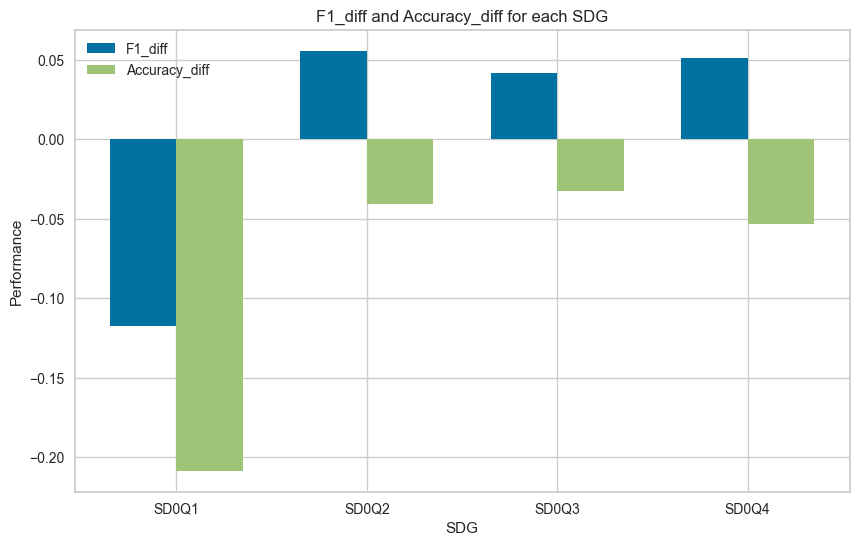

In [108]:
###### Barplot for the difference of performance over all SDG
# Set up the plot
bar_width = 0.35
fig, ax = plt.subplots(figsize=(10, 6))

# Create an index for the SDGs
index = np.arange(len(combined_data['SDG']))

# Create the bars for F1_diff and Accuracy_diff
f1_diff_bars = ax.bar(index, combined_data['F1_diff'], bar_width, label='F1_diff')
accuracy_diff_bars = ax.bar(index + bar_width, combined_data['Accuracy_diff'], bar_width, label='Accuracy_diff')

# Set up the x-axis labels and title
ax.set_xlabel('SDG')
ax.set_ylabel('Performance')
ax.set_title('F1_diff and Accuracy_diff for each SDG')

# Set the ticks and labels on the x-axis
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(combined_data['SDG'])

# Add the legend
ax.legend()

# Display the plot
plt.show()


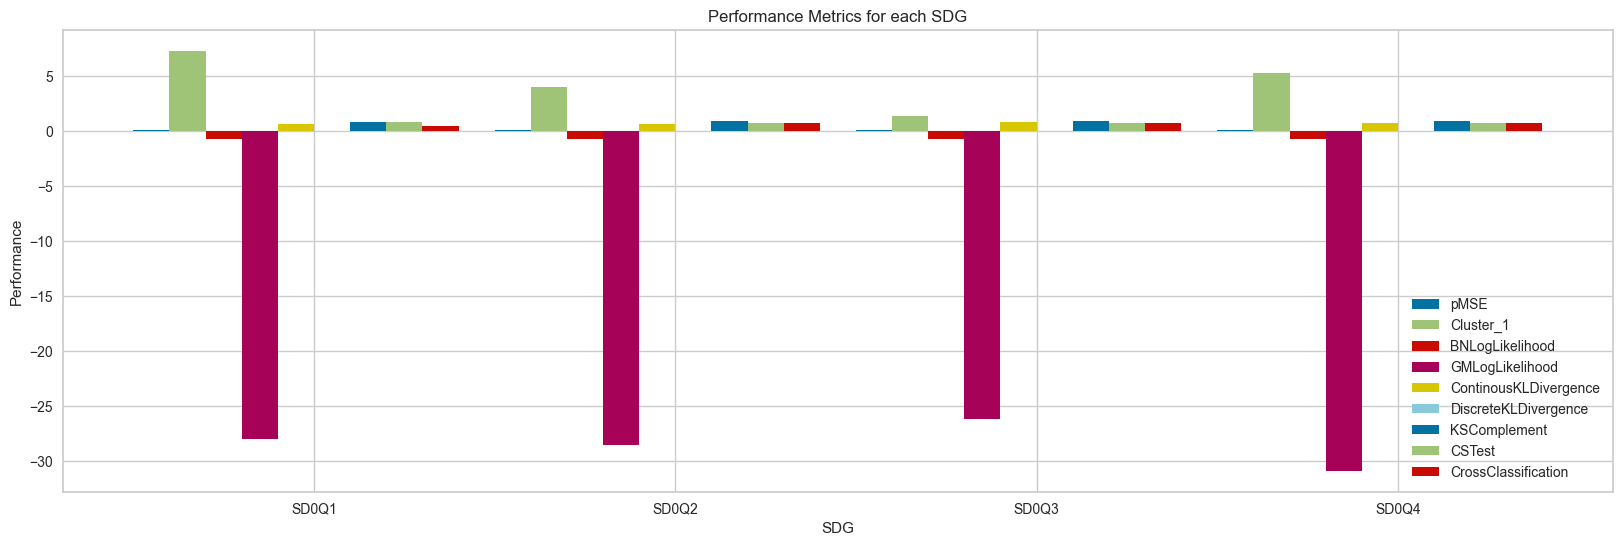

In [116]:
# List of columns
pf_columns = ['pMSE', 'Cluster_1', 'BNLogLikelihood', 'GMLogLikelihood',
              'ContinousKLDivergence', 'DiscreteKLDivergence', 'KSComplement', 'CSTest', 'CrossClassification']

# Set up the plot
bar_width = 0.1
fig, ax = plt.subplots(figsize=(20, 6))

# Create an index for the SDGs
index = np.arange(len(combined_data['SDG']))

# Create bars for each column
for i, col in enumerate(pf_columns):
    ax.bar(index + i * bar_width, combined_data[col], bar_width, label=col)

# Set up the x-axis labels and title
ax.set_xlabel('SDG')
ax.set_ylabel('Performance')
ax.set_title('Performance Metrics for each SDG')

# Set the ticks and labels on the x-axis
ax.set_xticks(index + len(pf_columns) * bar_width / 2)
ax.set_xticklabels(combined_data['SDG'])

# Add the legend
ax.legend()

# Display the plot
plt.show()


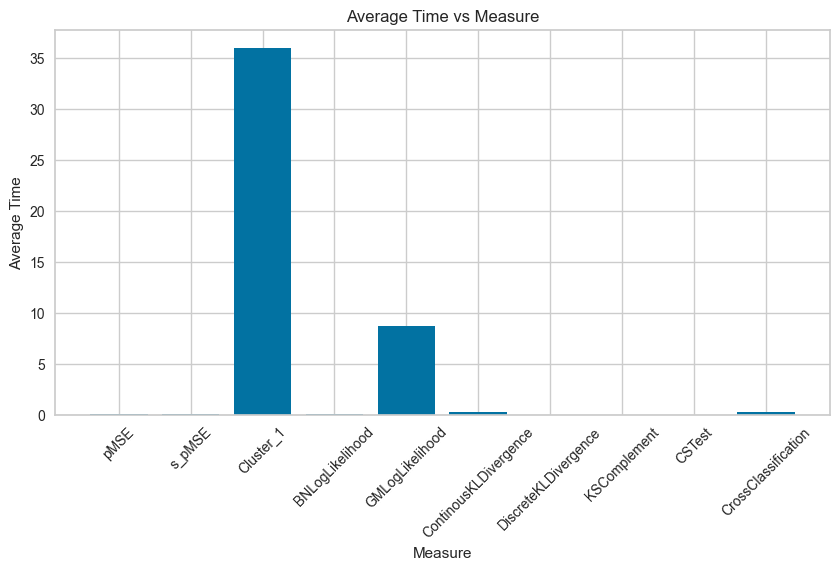

In [12]:
# Provided DataFrame
data = m_pf

# Columns with "_time" suffix
time_columns = ['pMSE_time', 's_pMSE_time', 'Cluster_1_time', 'BNLogLikelihood_time', 'GMLogLikelihood_time',
                'ContinousKLDivergence_time', 'DiscreteKLDivergence_time', 'KSComplement_time', 'CSTest_time',
                'CrossClassification_time']

# Calculate the mean of the columns
mean_times = data[time_columns].mean()

# Prepare the data for the bar plot
bar_data = pd.DataFrame({'measure': [col[:-5] for col in time_columns], 'mean_time': mean_times.values})

# Create a bar plot
plt.figure(figsize=(10, 5))
plt.bar(bar_data['measure'], bar_data['mean_time'])
plt.xlabel('Measure')
plt.ylabel('Average Time')
plt.title('Average Time vs Measure')
plt.xticks(rotation=45)
plt.show()

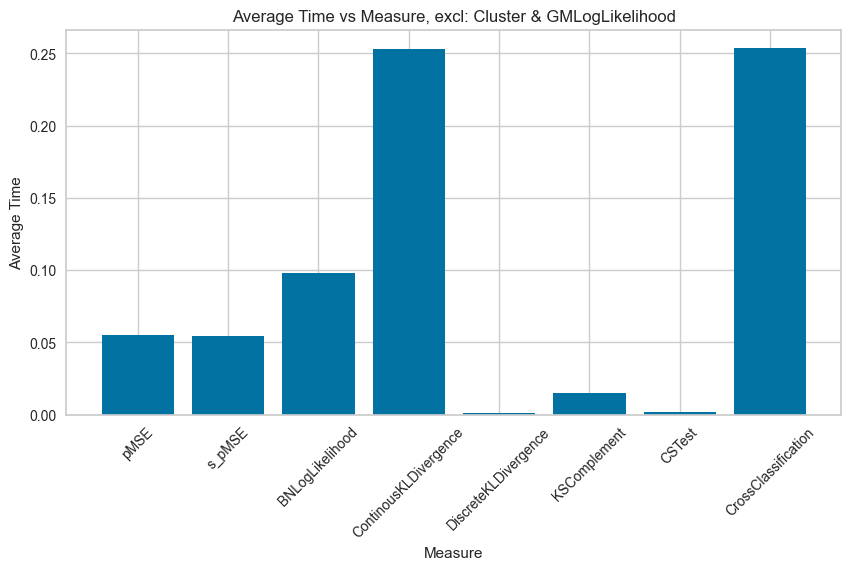

In [13]:
# Provided DataFrame
data = m_pf

# Columns with "_time" suffix
time_columns = ['pMSE_time', 's_pMSE_time', 'BNLogLikelihood_time',
                'ContinousKLDivergence_time', 'DiscreteKLDivergence_time', 'KSComplement_time', 'CSTest_time',
                'CrossClassification_time']

# Calculate the mean of the columns
mean_times = data[time_columns].mean()

# Prepare the data for the bar plot
bar_data = pd.DataFrame({'measure': [col[:-5] for col in time_columns], 'mean_time': mean_times.values})

# Create a bar plot
plt.figure(figsize=(10, 5))
plt.bar(bar_data['measure'], bar_data['mean_time'])
plt.xlabel('Measure')
plt.ylabel('Average Time')
plt.title('Average Time vs Measure, excl: Cluster & GMLogLikelihood')
plt.xticks(rotation=45)
plt.show()